In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

# Pad aanpassen aan jouw situatie
main_path = 'C:\\Users\\luukj\\Documents\\GitHub\\Project-2.1\\metingen\\metingen suiker'
os.chdir(main_path)

# constants
lambda_laser = 532e-9  # wavelength of the laser in meters
d_sugar = 1e-2          # thickness in meters
d_cuvett = 1.25e-2 - d_sugar  # thickness in meters
n_cuvett = 1.59         # refractive index of the cuvett
n_air = 1.0             # refractive index of air

n_water_532 = 1.3382
f_sacharose = 1.77e-3
V_totaal = 3

win_size = 3 
prom = 0.23

# Zet op True om piekplots te tonen
check = True

In [2]:
def lin(a, x, b):
    return a * x + b

def concentratie_correctie(V, C):
    return (C / 3) * 100

def read(name, subdir):
    fname = str(name) + '.csv'
    path = os.path.join(subdir, fname) if subdir else fname
    df = pd.read_csv(
        path,
        skiprows=2,
        delimiter=',',
        names=['X', 'CH1', 'dummy1', 'dummy2'],
        engine='python'
    )
    return df

def N_fit_suiker(theta_in, n_sugar):
    """Function to fit the refractive index data."""
    theta_in_rad = np.deg2rad(theta_in)
    return 2 / lambda_laser * (
        2 * d_cuvett * (np.sqrt(n_cuvett**2 - n_air**2 * np.sin(theta_in_rad)**2) - n_air * np.cos(theta_in_rad))
        + d_sugar * (np.sqrt(n_sugar**2 - n_air**2 * np.sin(theta_in_rad)**2) - n_air * np.cos(theta_in_rad))
        - (2 * n_cuvett * d_cuvett + n_sugar * d_sugar - 2 * d_cuvett * n_air - d_sugar * n_air)
    )

def fringes(naam, var_window_size, var_prominence, subdir, show_plots=False, x_ranges=None):
    """
    Bepaalt fringes, toont optioneel piekdetectieplots en print samenvatting.
    Je kunt optioneel per bestand een X-bereik instellen via een dict 'x_ranges':
        {'0.5ml_0g2g': (0.1, 0.8), '0.5ml_2g4g': (0.2, 1.0), ...}
    Alleen pieken BINNEN dat X-bereik worden geteld.
    """
    naam_1 = f"{naam}_0g2g"
    naam_2 = f"{naam}_2g4g"
    naam_3 = f"{naam}_4g6g"
    naam_4 = f"{naam}_6g8g"
    naam_5 = f"{naam}_8g10g"
    names = [naam_1, naam_2, naam_3, naam_4, naam_5]

    dfs, peaks_list = [], []

    print(f"\n=== Piekoverzicht voor {naam} (subdir: {subdir}) ===")
    total_peaks = 0

    for nm in names:
        df = read(nm, subdir)
        df['rolling'] = df['CH1'].rolling(window=var_window_size, center=True).mean()

        # Bepaal X-bereik
        if x_ranges and nm in x_ranges:
            x_min, x_max = x_ranges[nm]
            mask = (df['X'] >= x_min) & (df['X'] <= x_max)
            df_window = df[mask]
        else:
            df_window = df
            x_min, x_max = df['X'].min(), df['X'].max()

        # Piekdetectie alleen binnen geselecteerd X-bereik
        peaks, _ = find_peaks(df_window['rolling'], prominence=var_prominence)

        # Opslaan voor later gebruik
        dfs.append((df, df_window, peaks, (x_min, x_max)))
        total_peaks += len(peaks)
        print(f"{nm:<20} → {len(peaks):>3} pieken (X bereik [{x_min:.2f}, {x_max:.2f}])")

    print(f"Totaal geteld: {total_peaks} pieken\n")

    # Plotten (alleen bij check=True en show_plots=True)
    if check and show_plots:
        fig, axes = plt.subplots(len(dfs), 1, figsize=(8, 12), sharex=True)
        for ax, (df, df_window, peaks, (x_min, x_max)) in zip(axes, dfs):
            ax.plot(df['X'], df['CH1'], alpha=0.4, label='Ruwe data')
            ax.plot(df['X'], df['rolling'], color='orange', label='Rolling gemiddelde')

            # Highlight X-bereik visueel
            ax.axvspan(x_min, x_max, color='green', alpha=0.1, label='Gebruikt X-bereik')

            # Pieken binnen bereik tonen
            if len(peaks) > 0:
                ax.plot(df_window['X'].iloc[peaks], df_window['rolling'].iloc[peaks],
                        'rx', label='Gevonden pieken')
                for j, p in enumerate(peaks):
                    ax.text(df_window['X'].iloc[p], df_window['rolling'].iloc[p] + 0.02,
                            str(j + 1), color='red', fontsize=8, ha='center')

            ax.set_title(f"{df_window.index.name or naam}")
            ax.legend()
            ax.grid(True)

        axes[-1].set_xlabel("Hoek (°)")
        plt.tight_layout()
        #plt.show()

    # Cumulatieve fringes berekenen
    fringes_0 = 0
    fringes_cum = [fringes_0]
    for _, _, peaks, _ in dfs:
        fringes_cum.append(fringes_cum[-1] + len(peaks))

    return np.array(fringes_cum)



def fit_multidata(hoek_graden, N, naam='', check=False):
    """
    Fit de fringedata aan het model en retourneert de best-fit n_suiker.
    Houdt rekening met relatieve verschuivingen (ΔN).
    """
    N = np.array(N, dtype=float)
    N -= N[0]  # relatieve fringes

    def model_shifted(theta, n_suiker):
        vals = N_fit_suiker(theta, n_suiker)
        return vals - vals[0]

    # Fit uitvoeren
    popt, pcov = curve_fit(model_shifted, hoek_graden, N, p0=[1.33])
    n_fit = popt[0]
    return popt

def plot_datagraphs(naam, x, y, n_line, n_fit):
    plt.figure(naam)
    plt.scatter(x, y, label='Measured Data', color='red')
    plt.plot(theta_fit, n_line, label=f'Fitted Curve (n={n_fit[0]:.2f})', color='blue')
    plt.plot(theta_fit, N_fit_suiker(theta_fit, 1.33), label='n = 1.33', color='orange')
    plt.xlabel('Theta (degrees)')
    plt.ylabel('N')
    plt.title('Refractive Index Fit')
    plt.xlim(0, 12)
    plt.ylim(0, 250)
    plt.legend()
    plt.grid()

In [6]:
theta_graden = np.array([0, 2, 4, 6, 8, 10])
theta_fit = np.linspace(0, 12, 100)
C = np.array([0, 0.25, 0.5, 0.75, 1.0])
C_cor = concentratie_correctie(V_totaal, C)
n_theorie = lin(f_sacharose, C_cor, n_water_532)


=== Piekoverzicht voor 0.25ml (subdir: 0.25) ===
0.25ml_0g2g          →  14 pieken (X bereik [0.20, 630.00])
0.25ml_2g4g          →  30 pieken (X bereik [230.00, 905.00])
0.25ml_4g6g          →  42 pieken (X bereik [185.00, 1091.00])
0.25ml_6g8g          →  66 pieken (X bereik [145.00, 1010.00])
0.25ml_8g10g         →  81 pieken (X bereik [25.00, 1040.00])
Totaal geteld: 233 pieken


=== Piekoverzicht voor 0.5ml (subdir: 0.5) ===
0.5ml_0g2g           →  25 pieken (X bereik [0.20, 1075.00])
0.5ml_2g4g           →  24 pieken (X bereik [245.00, 925.00])
0.5ml_4g6g           →  46 pieken (X bereik [338.00, 1048.00])
0.5ml_6g8g           →  67 pieken (X bereik [141.00, 832.00])
0.5ml_8g10g          →  63 pieken (X bereik [25.00, 940.00])
Totaal geteld: 225 pieken


=== Piekoverzicht voor 0.75ml (subdir: 0.75) ===
0.75ml_0g2g          →  25 pieken (X bereik [124.00, 825.00])
0.75ml_2g4g          →  29 pieken (X bereik [130.00, 790.00])
0.75ml_4g6g          →  52 pieken (X bereik [265.00, 11

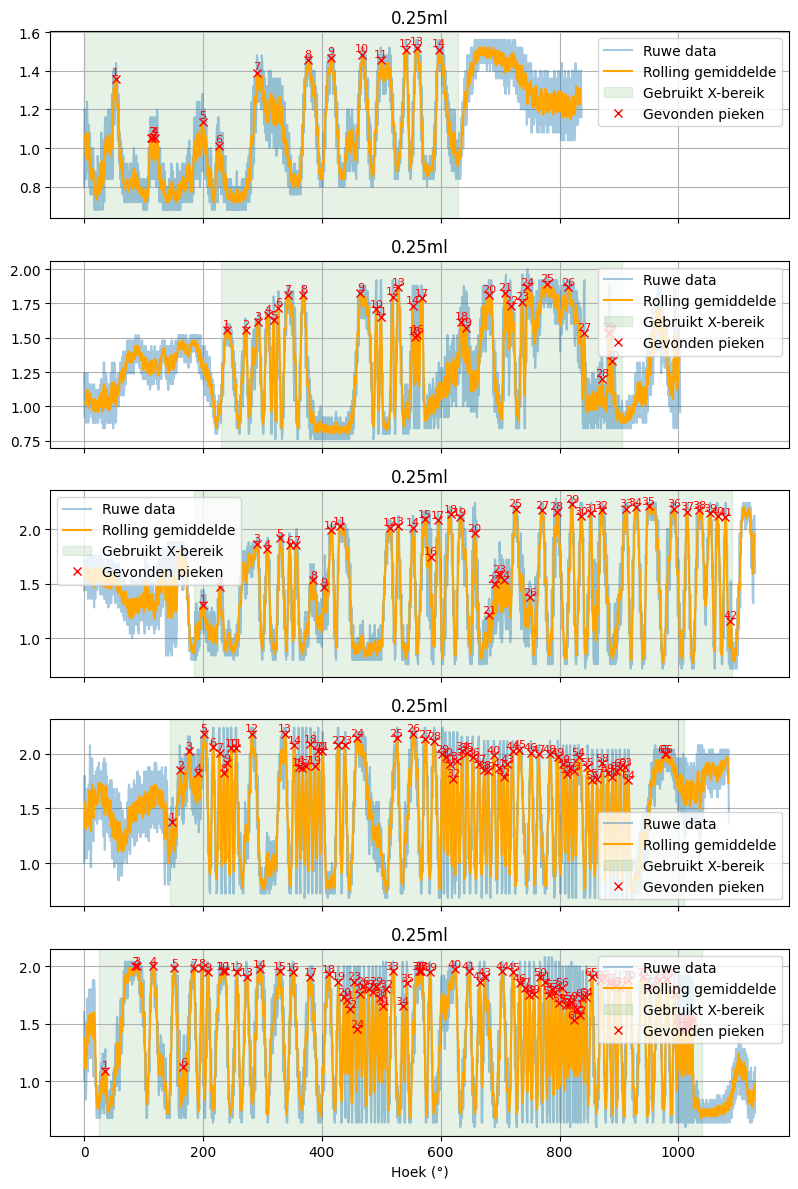

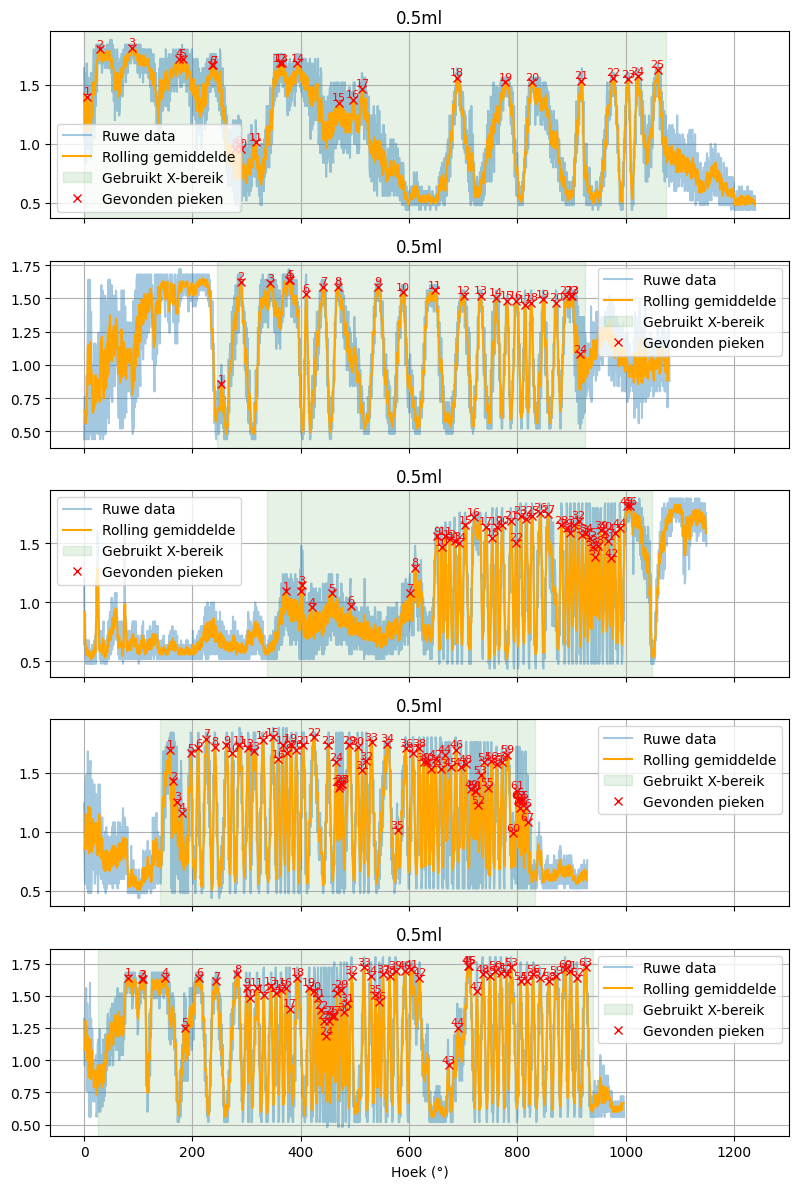

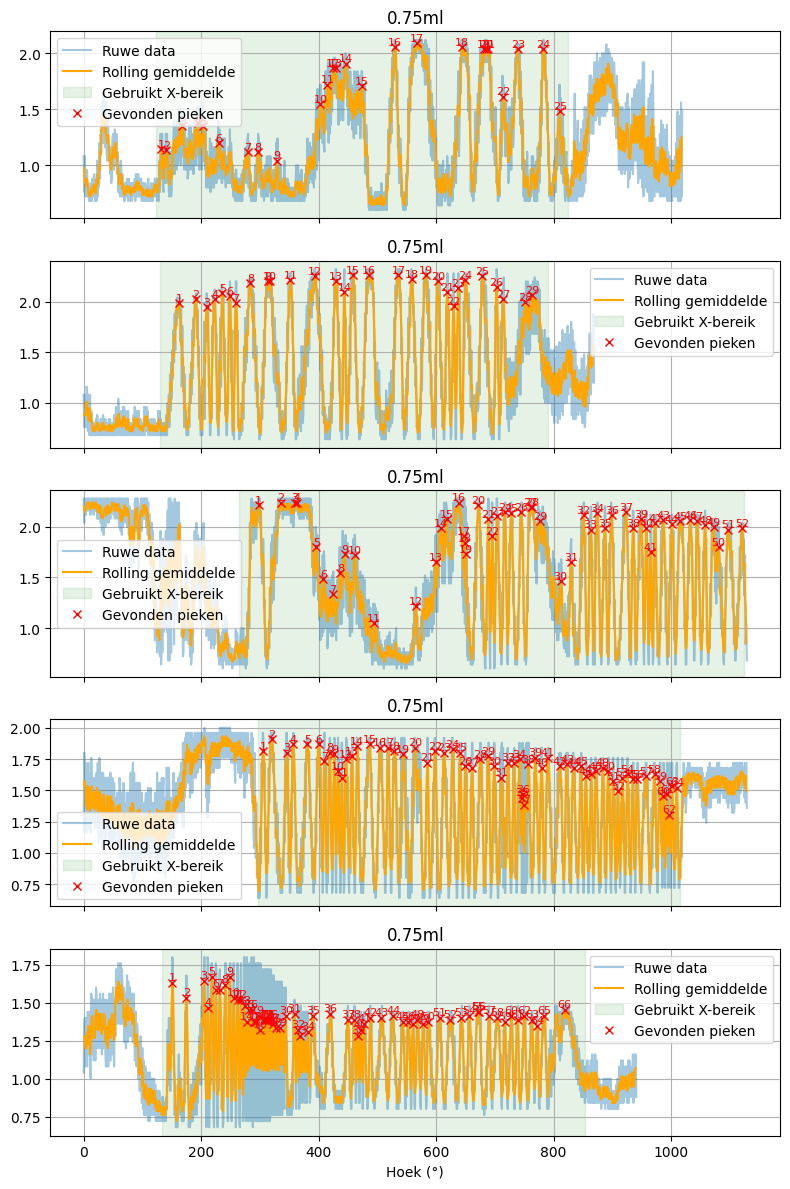

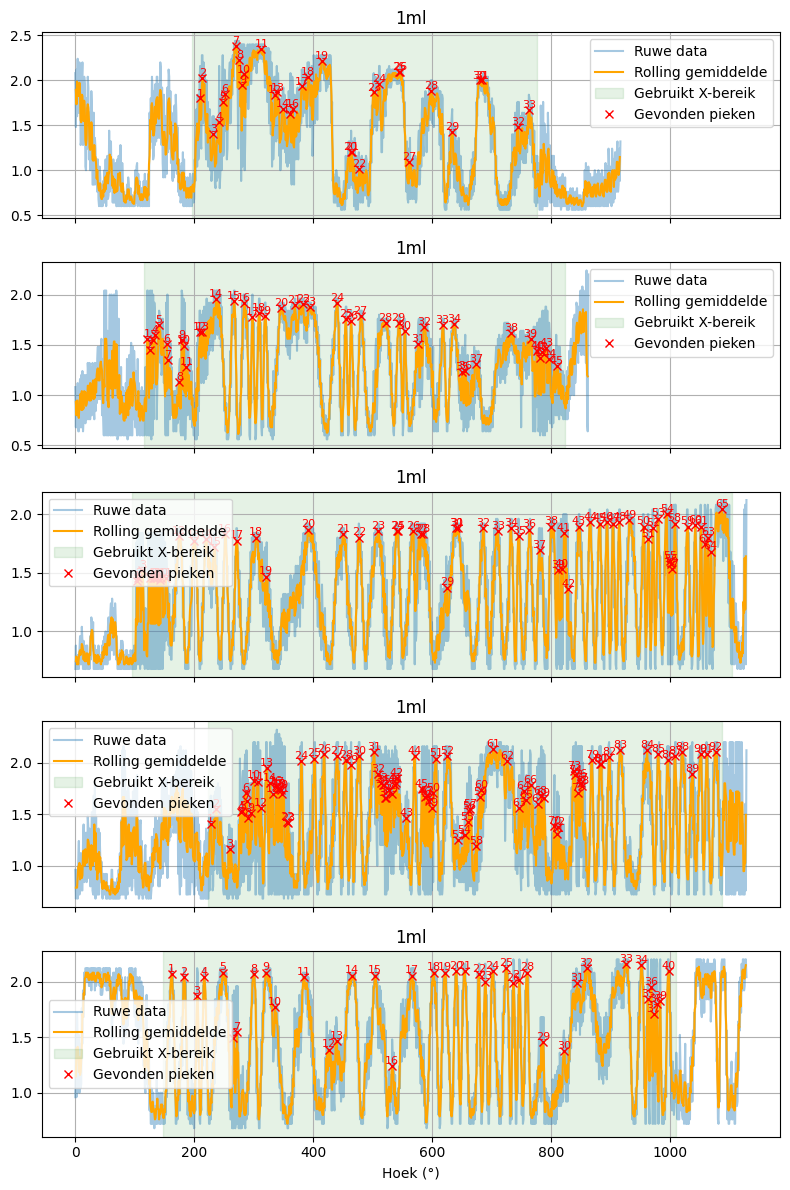

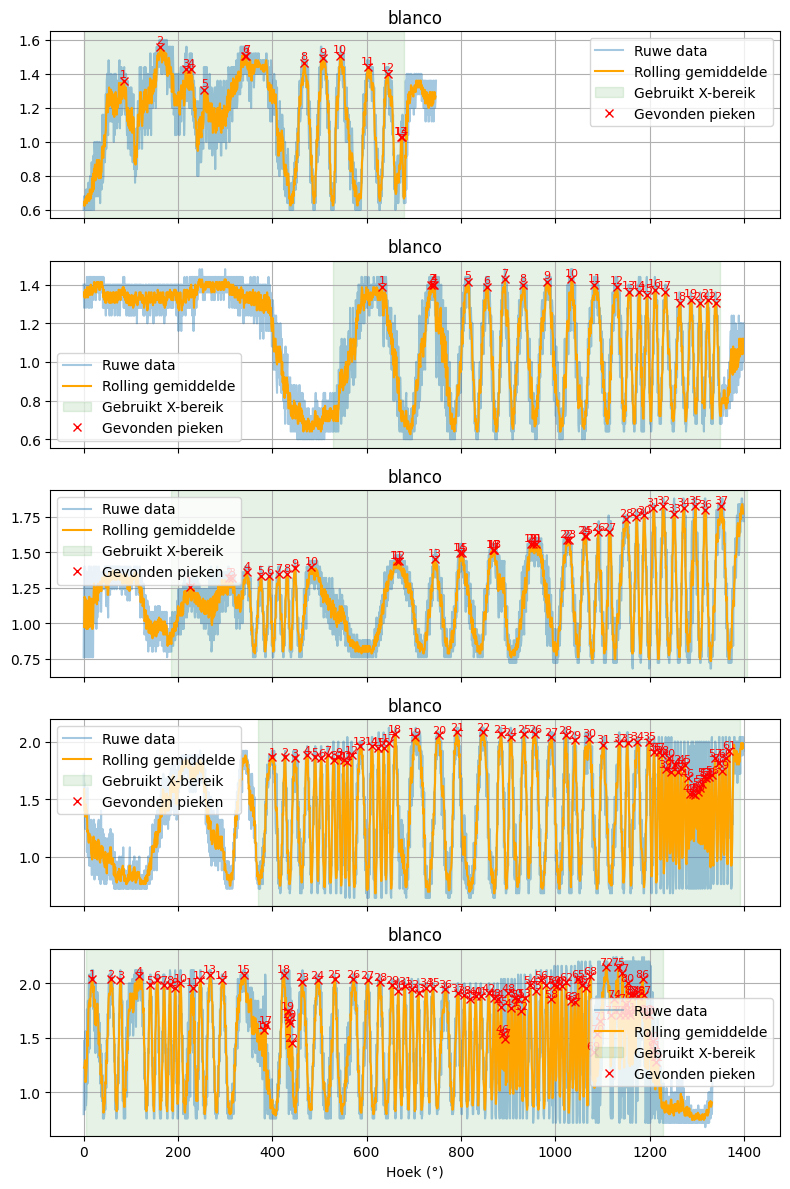

In [9]:
x_ranges_025ml = {
    '0.25ml_0g2g': (0.2, 630),
    '0.25ml_2g4g': (230, 905),
    '0.25ml_4g6g': (185, 1091),
    '0.25ml_6g8g': (145, 1010),
    '0.25ml_8g10g': (25, 1040)
}
x_ranges_05ml = {
    '0.5ml_0g2g': (0.2, 1075),
    '0.5ml_2g4g': (245, 925),
    '0.5ml_4g6g': (338, 1048),
    '0.5ml_6g8g': (141, 832),
    '0.5ml_8g10g': (25, 940)
}
x_ranges_075ml = {
    '0.75ml_0g2g': (124, 825),
    '0.75ml_2g4g': (130, 790),
    '0.75ml_4g6g': (265, 1124),
    '0.75ml_6g8g': (297, 1015),
    '0.75ml_8g10g': (133, 853)
}
x_ranges_1ml = {
    '1ml_0g2g': (197, 777),
    '1ml_2g4g': (115, 823),
    '1ml_4g6g': (95, 1104),
    '1ml_6g8g': (223, 1088),
    '1ml_8g10g': (148, 1010)
}
x_ranges_blanco = {
    'blanco_0g2g': (1, 679),
    'blanco_2g4g': (529, 1350),
    'blanco_4g6g': (186, 1406),
    'blanco_6g8g': (370, 1391),
    'blanco_8g10g': (6, 1229)
}

fringes_025ml = fringes(
    '0.25ml', win_size, prom,
    subdir='0.25', show_plots=True,
    x_ranges=x_ranges_025ml
)
fringes_05ml = fringes(
    '0.5ml', win_size, prom,
    subdir='0.5', show_plots=True,
    x_ranges=x_ranges_05ml
)
fringes_075ml = fringes(
    '0.75ml', win_size, prom,
    subdir='0.75', show_plots=True,
    x_ranges=x_ranges_075ml
)
fringes_1ml = fringes(
    '1ml', win_size, prom,
    subdir='1', show_plots=True,
    x_ranges=x_ranges_1ml
)
fringes_blanco = fringes(
    'blanco', win_size, prom,
    subdir='blanco', show_plots=True,
    x_ranges=x_ranges_blanco
)

C(m/v%) [ 0.          8.33333333 16.66666667 25.         33.33333333]
n [1.24408262 1.28762395 1.2929222  1.33294166 1.560297  ]
n_theorie [1.3382  1.35295 1.3677  1.38245 1.3972 ]


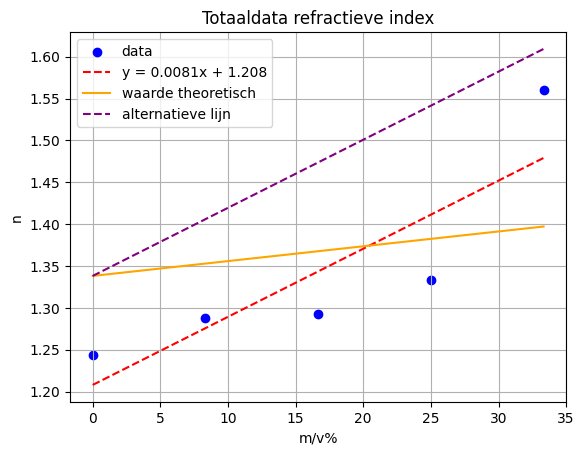

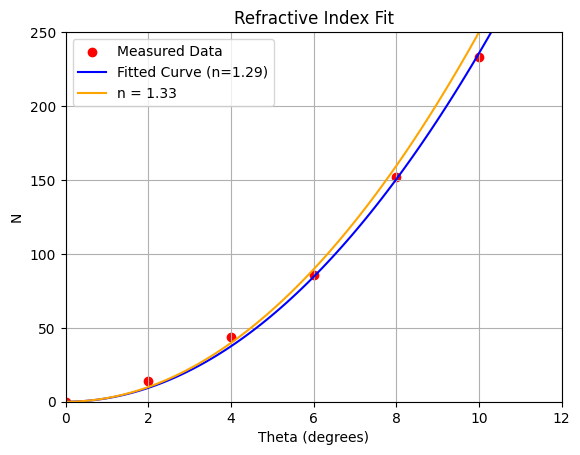

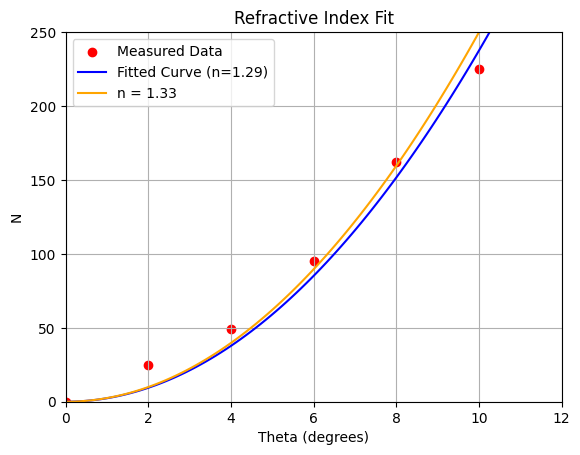

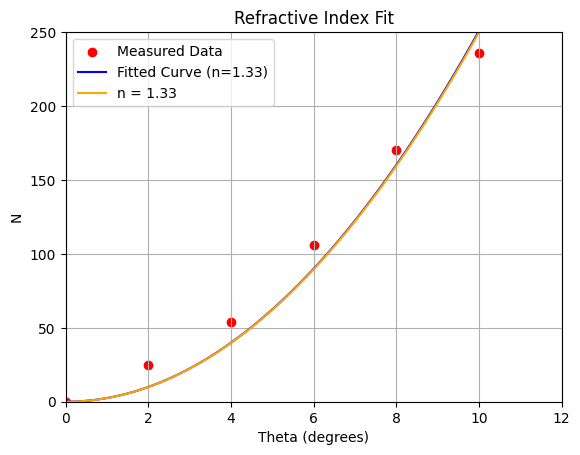

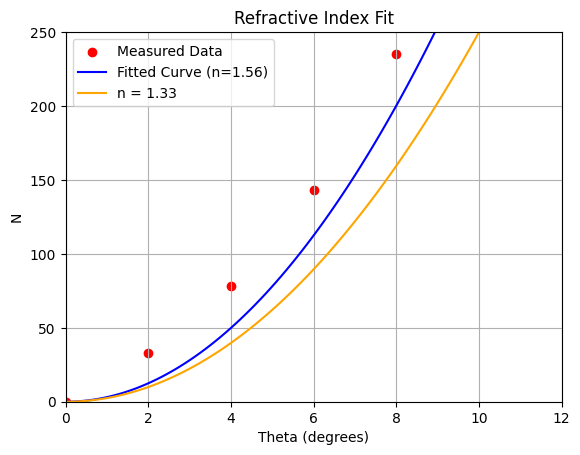

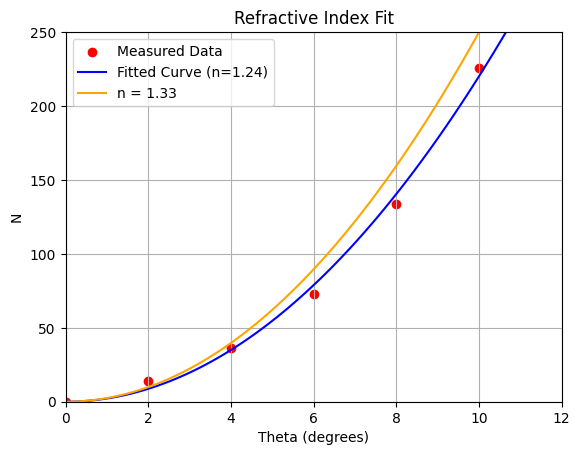

[  0  14  44  86 152 233]


In [8]:
fit_025ml = fit_multidata(theta_graden, fringes_025ml)
fit_05ml  = fit_multidata(theta_graden, fringes_05ml)
fit_075ml = fit_multidata(theta_graden, fringes_075ml)
fit_1ml   = fit_multidata(theta_graden, fringes_1ml)
fit_blanco = fit_multidata(theta_graden, fringes_blanco)

fit_025ml = fit_multidata(theta_graden, fringes_025ml, naam='0.25ml', check=check)
fit_05ml = fit_multidata(theta_graden, fringes_05ml, naam='0.5ml', check=check)
fit_075ml = fit_multidata(theta_graden, fringes_075ml, naam='0.75ml', check=check)
fit_1ml = fit_multidata(theta_graden, fringes_1ml, naam='1ml', check=check)
fit_blanco = fit_multidata(theta_graden, fringes_blanco, naam='blanco', check=check)

fit_lijn_025ml = N_fit_suiker(theta_fit, *fit_025ml)
fit_lijn_05ml  = N_fit_suiker(theta_fit, *fit_05ml)
fit_lijn_075ml = N_fit_suiker(theta_fit, *fit_075ml)
fit_lijn_1ml   = N_fit_suiker(theta_fit, *fit_1ml)
fit_lijn_blanco = N_fit_suiker(theta_fit, *fit_blanco)

n = np.array([float(fit_blanco[0]), float(fit_025ml[0]), float(fit_05ml[0]),
              float(fit_075ml[0]), float(fit_1ml[0])])

#
#C_cor = np.delete(C_cor,-1)
#n = np.delete(n,-1)
#n_theorie = np.delete(n_theorie,-1)

# Lineaire fit over alle data
popt, pcov = curve_fit(lin, C_cor, n)
slope, intercept = popt
trend = lin(slope, C_cor, intercept)
trend_alt = lin(slope, C_cor, n_water_532)

# Samenvattende plot
plt.figure(0)
plt.scatter(C_cor, n, label='data', color='blue')
plt.plot(C_cor, trend, label=f'y = {round(slope,4)}x + {round(intercept,4)}', color='red', linestyle='--')
plt.plot(C_cor, n_theorie, label='waarde theoretisch', color='orange')
plt.plot(C_cor, trend_alt, label='alternatieve lijn', color='purple', linestyle='--')
plt.xlabel('m/v%')
plt.ylabel('n')
plt.legend()
plt.title('Totaaldata refractieve index')
plt.grid()

# Detailplots alleen als check=True
if check:
    plot_datagraphs('0.25ml', theta_graden, fringes_025ml, fit_lijn_025ml, fit_025ml)
    plot_datagraphs('0.5ml', theta_graden, fringes_05ml, fit_lijn_05ml, fit_05ml)
    plot_datagraphs('0.75ml', theta_graden, fringes_075ml, fit_lijn_075ml, fit_075ml)
    plot_datagraphs('1ml', theta_graden, fringes_1ml, fit_lijn_1ml, fit_1ml)
    plot_datagraphs('blanco', theta_graden, fringes_blanco, fit_lijn_blanco, fit_blanco)

print('C(m/v%)',C_cor)
print('n',n)
print('n_theorie',n_theorie)

plt.show()

print(fringes_025ml)